<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/ResNet(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, ReLU, Add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Step 1: Libraries imported successfully!")

# Execute this step first, then move to Step 2


Step 1: Libraries imported successfully!


In [27]:



# ==============================================================================
# Step 2: Load and preprocess data
# ==============================================================================

def load_and_preprocess_data():
    """Load and preprocess the CSV files"""
    print("\nStep 2: Loading data...")

    # Load CSV files
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/training.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validating.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/testing.csv')

    print(f"Train data shape: {train_df.shape}")
    print(f"Validation data shape: {val_df.shape}")
    print(f"Test data shape: {test_df.shape}")

    return train_df, val_df, test_df

# Execute Step 2
train_df, val_df, test_df = load_and_preprocess_data()




Step 2: Loading data...
Train data shape: (4928, 86)
Validation data shape: (1056, 86)
Test data shape: (1056, 86)


In [28]:


# ==============================================================================
# Step 3: Create quantile-based labels (6 categories)
# ==============================================================================

def create_quantile_labels(train_df, val_df, test_df):
    """Create quantile-based labels for production (6 categories)"""
    print("\nStep 3: Creating quantile-based labels (6 categories)...")

    # Calculate quantiles based on training data (5 quantiles for 6 categories)
    production_col = 'Production (M.Ton)'
    quantiles = train_df[production_col].quantile([0.16667, 0.33333, 0.5, 0.66667, 0.83333]).values

    print(f"Quantile thresholds: {quantiles}")

    def assign_labels(production_values, quantiles):
        labels = []
        for val in production_values:
            if val <= quantiles[0]:
                labels.append(0)  # Very Low
            elif val <= quantiles[1]:
                labels.append(1)  # Low
            elif val <= quantiles[2]:
                labels.append(2)  # Medium
            elif val <= quantiles[3]:
                labels.append(3)  # High
            elif val <= quantiles[4]:
                labels.append(4)  # Very High
            else:
                labels.append(5)  # Extremely High
        return np.array(labels)

    # Create labels for all datasets
    y_train = assign_labels(train_df[production_col], quantiles)
    y_val = assign_labels(val_df[production_col], quantiles)
    y_test = assign_labels(test_df[production_col], quantiles)

    # Print label distribution
    label_names = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
    print("\nLabel distribution:")
    for i, name in enumerate(label_names):
        print(f"{name}: Train={np.sum(y_train==i)}, Val={np.sum(y_val==i)}, Test={np.sum(y_test==i)}")

    return y_train, y_val, y_test, quantiles

# Execute Step 3
y_train, y_val, y_test, quantiles = create_quantile_labels(train_df, val_df, test_df)




Step 3: Creating quantile-based labels (6 categories)...
Quantile thresholds: [ 417.         996.95073   2027.        3717.04927   7522.6118492]

Label distribution:
Very Low: Train=824, Val=188, Test=190
Low: Train=819, Val=181, Test=165
Medium: Train=821, Val=170, Test=180
High: Train=821, Val=176, Test=164
Very High: Train=821, Val=171, Test=195
Extremely High: Train=822, Val=170, Test=162


In [29]:



# ==============================================================================
# Step 4: Prepare features
# ==============================================================================

def prepare_features(train_df, val_df, test_df):
    """Prepare feature matrices"""
    print("\nStep 4: Preparing features...")

    # Drop the target column
    feature_cols = [col for col in train_df.columns if col != 'Production (M.Ton)']

    X_train = train_df[feature_cols].values
    X_val = val_df[feature_cols].values
    X_test = test_df[feature_cols].values

    # Handle missing values
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Feature matrix shapes:")
    print(f"X_train: {X_train_scaled.shape}")
    print(f"X_val: {X_val_scaled.shape}")
    print(f"X_test: {X_test_scaled.shape}")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Execute Step 4
X_train, X_val, X_test, scaler = prepare_features(train_df, val_df, test_df)



Step 4: Preparing features...
Feature matrix shapes:
X_train: (4928, 85)
X_val: (1056, 85)
X_test: (1056, 85)


In [30]:



# ==============================================================================
# Step 5: Build ResNet model (6 classes)
# ==============================================================================

def residual_block(x, units, dropout_rate=0.2):
    """Create a residual block"""
    # Save input for skip connection
    shortcut = x

    # First layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    # Second layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != units:
        shortcut = Dense(units)(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    return x

def build_resnet_model(input_dim, num_classes=6):
    """Build ResNet model for classification (6 classes)"""
    print("\nStep 5: Building ResNet model for 6 classes...")

    # Input layer
    inputs = Input(shape=(input_dim,))

    # Initial dense layer
    x = Dense(256)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    # Residual blocks
    x = residual_block(x, 512, 0.3)
    x = residual_block(x, 512, 0.3)
    x = residual_block(x, 256, 0.2)
    x = residual_block(x, 256, 0.2)
    x = residual_block(x, 128, 0.2)

    # Final layers
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    # Output layer (6 classes)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model architecture:")
    model.summary()

    return model

# Execute Step 5
model = build_resnet_model(X_train.shape[1])




Step 5: Building ResNet model for 6 classes...
Model architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     22,016 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256)       │          0 │ re_lu_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 512)       │    131,584 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_33[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 512)       │          0 │ re_lu_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 512)       │    262,656 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_34[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 512)       │    131,584 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 512)       │          0 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 512)       │          0 │ re_lu_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │    262,656 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 512)       │          0 │ re_lu_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 512)       │    262,656 │ dropout_27[0][0]

 Total params: 1,638,726 (6.25 MB)

 Trainable params: 1,631,430 (6.22 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [31]:



# ==============================================================================
# Step 6: Train the model
# ==============================================================================

def train_model(model, X_train, y_train, X_val, y_val, epochs=100):
    """Train the ResNet model"""
    print(f"\nStep 6: Training model for {epochs} epochs...")

    # Convert labels to categorical (6 classes)
    y_train_cat = to_categorical(y_train, 6)
    y_val_cat = to_categorical(y_val, 6)

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return history

# Execute Step 6
history = train_model(model, X_train, y_train, X_val, y_val, epochs=100)



Step 6: Training model for 100 epochs...
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.1701 - loss: 2.0822 - val_accuracy: 0.3627 - val_loss: 1.4715 - learning_rate: 0.0010
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3469 - loss: 1.5354 - val_accuracy: 0.4403 - val_loss: 1.2887 - learning_rate: 0.0010
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4292 - loss: 1.3381 - val_accuracy: 0.5597 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5020 - loss: 1.2064 - val_accuracy: 0.6070 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5503 - loss: 1.1127 - val_accuracy: 0.6534 - val_loss: 0.8769 - learning_rate: 0.0010
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5949 - loss: 1.0207 - val_accuracy: 0.6837 - val_loss: 0.8082 - learning_rate: 0.0010
Epoch 7/100
154/154 ━━━━━━━━━━━━━


Step 7: Plotting training history with smooth curves...


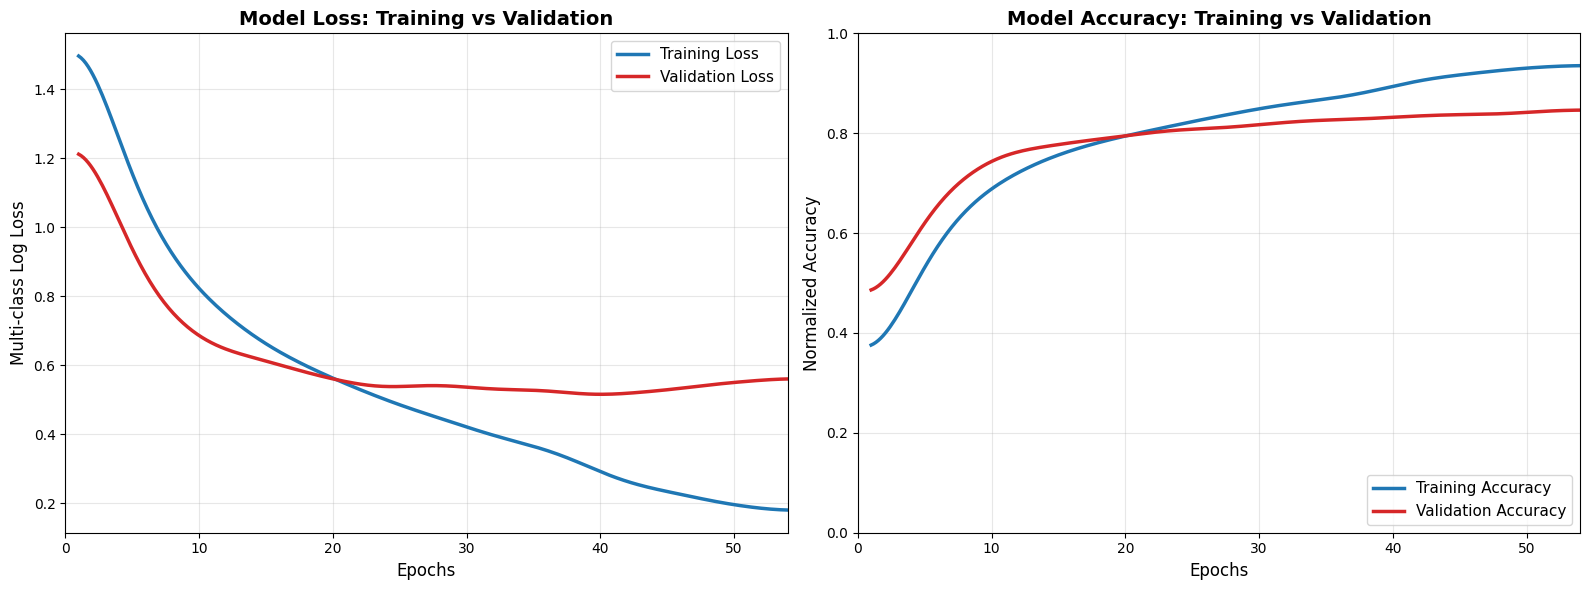

In [32]:



# ==============================================================================
# Step 7: plotting function for smooth curves
# ==============================================================================

def plot_training_history_smooth(history, sigma=2.5):
    """Plot training and validation accuracy/loss with ultra-smooth curves like the reference image"""
    print("\nStep 7: Plotting training history with smooth curves...")

    # Extract history data
    epochs = np.array(range(1, len(history.history['accuracy']) + 1))
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    train_loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    # Apply strong Gaussian smoothing for ultra-smooth curves
    train_acc_smooth = gaussian_filter1d(train_acc, sigma=sigma)
    val_acc_smooth = gaussian_filter1d(val_acc, sigma=sigma)
    train_loss_smooth = gaussian_filter1d(train_loss, sigma=sigma)
    val_loss_smooth = gaussian_filter1d(val_loss, sigma=sigma)

    # Create interpolated data for even smoother curves
    from scipy.interpolate import make_interp_spline
    epochs_smooth = np.linspace(epochs.min(), epochs.max(), 300)

    # Spline interpolation for ultra-smooth curves
    spl_train_acc = make_interp_spline(epochs, train_acc_smooth, k=3)
    spl_val_acc = make_interp_spline(epochs, val_acc_smooth, k=3)
    spl_train_loss = make_interp_spline(epochs, train_loss_smooth, k=3)
    spl_val_loss = make_interp_spline(epochs, val_loss_smooth, k=3)

    train_acc_final = spl_train_acc(epochs_smooth)
    val_acc_final = spl_val_acc(epochs_smooth)
    train_loss_final = spl_train_loss(epochs_smooth)
    val_loss_final = spl_val_loss(epochs_smooth)

    # Set up the plotting style to match reference image
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss (left subplot to match reference)
    ax1.plot(epochs_smooth, train_loss_final, '#1f77b4', linewidth=2.5, label='Training Loss')
    ax1.plot(epochs_smooth, val_loss_final, '#d62728', linewidth=2.5, label='Validation Loss')
    ax1.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Multi-class Log Loss', fontsize=12)
    ax1.legend(fontsize=11, loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, len(epochs)])

    # Plot Accuracy (right subplot to match reference)
    ax2.plot(epochs_smooth, train_acc_final, '#1f77b4', linewidth=2.5, label='Training Accuracy')
    ax2.plot(epochs_smooth, val_acc_final, '#d62728', linewidth=2.5, label='Validation Accuracy')
    ax2.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Normalized Accuracy', fontsize=12)
    ax2.legend(fontsize=11, loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, len(epochs)])
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

# Execute Step 7
plot_training_history_smooth(history)



In [33]:


# ==============================================================================
# Step 8: Evaluation functions
# ==============================================================================

def calculate_metrics(y_true, y_pred):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score (Weighted)': f1_weighted,
        'F1 Score (Macro)': f1_macro
    }

def plot_confusion_matrix(y_true, y_pred, title, dataset_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{title} - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

# Execute Step 8 - Make predictions
print("\nStep 8: Making predictions...")
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)




Step 8: Making predictions...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [34]:



# ==============================================================================
# Step 9: Calculate and display results
# ==============================================================================

# Calculate metrics for validation set
print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
val_metrics = calculate_metrics(y_val, y_val_pred)
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate metrics for test set
print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
test_metrics = calculate_metrics(y_test, y_test_pred)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")




VALIDATION SET RESULTS
Accuracy: 0.8352
Precision: 0.8357
Recall: 0.8352
F1 Score (Weighted): 0.8353
F1 Score (Macro): 0.8340

TEST SET RESULTS
Accuracy: 0.7964
Precision: 0.8017
Recall: 0.7964
F1 Score (Weighted): 0.7972
F1 Score (Macro): 0.7969



Step 10: Plotting confusion matrices...


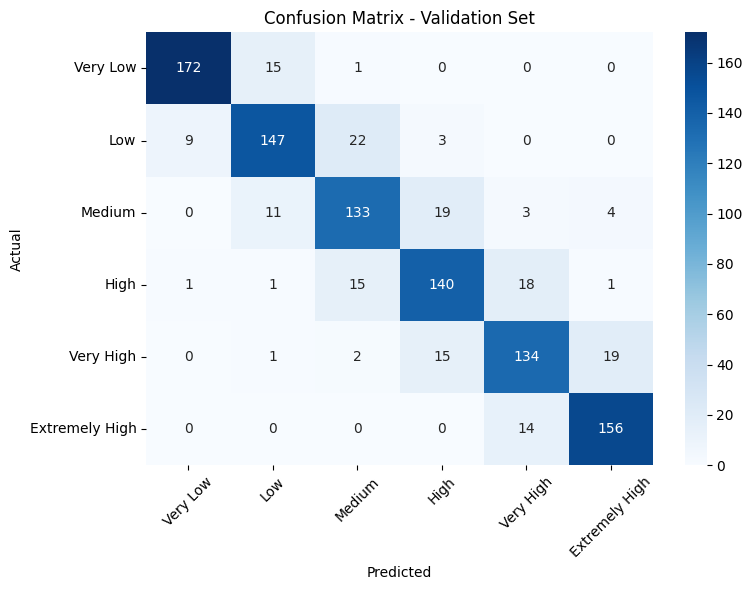

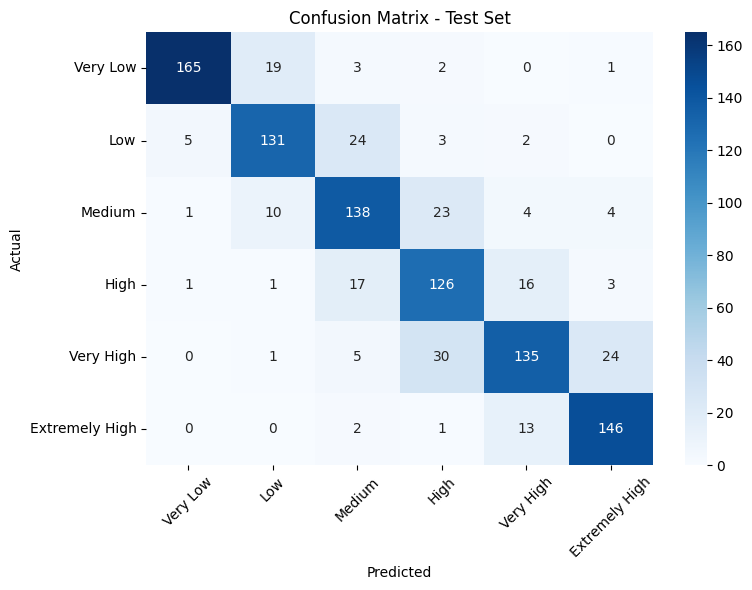

In [35]:



# ==============================================================================
# Step 10: Plot confusion matrices
# ==============================================================================

print("\nStep 10: Plotting confusion matrices...")
val_cm = plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix", "Validation Set")
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix", "Test Set")



In [36]:

# ==============================================================================
# Step 11: Detailed classification reports
# ==============================================================================

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT - VALIDATION")
print("="*50)
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
print(classification_report(y_val, y_val_pred, target_names=labels))

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT - TEST")
print("="*50)
print(classification_report(y_test, y_test_pred, target_names=labels))




DETAILED CLASSIFICATION REPORT - VALIDATION
                precision    recall  f1-score   support

      Very Low       0.95      0.91      0.93       188
           Low       0.84      0.81      0.83       181
        Medium       0.77      0.78      0.78       170
          High       0.79      0.80      0.79       176
     Very High       0.79      0.78      0.79       171
Extremely High       0.87      0.92      0.89       170

      accuracy                           0.84      1056
     macro avg       0.83      0.83      0.83      1056
  weighted avg       0.84      0.84      0.84      1056


DETAILED CLASSIFICATION REPORT - TEST
                precision    recall  f1-score   support

      Very Low       0.96      0.87      0.91       190
           Low       0.81      0.79      0.80       165
        Medium       0.73      0.77      0.75       180
          High       0.68      0.77      0.72       164
     Very High       0.79      0.69      0.74       195
Extremely High  

In [37]:



# ==============================================================================
# Step 12: Final summary
# ==============================================================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Model trained successfully with 6 classes!")
print(f"Classes: Very Low, Low, Medium, High, Very High, Extremely High")
print(f"Validation Accuracy: {val_metrics['Accuracy']:.4f}")
print(f"Validation Macro F1: {val_metrics['F1 Score (Macro)']:.4f}")
print(f"Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"Test Macro F1: {test_metrics['F1 Score (Macro)']:.4f}")

print("\nPipeline completed successfully!")

# Optional: Save model
# model.save('resnet_crop_production_6class_model.h5')
# print("Model saved as 'resnet_crop_production_6class_model.h5'")


FINAL SUMMARY
Model trained successfully with 6 classes!
Classes: Very Low, Low, Medium, High, Very High, Extremely High
Validation Accuracy: 0.8352
Validation Macro F1: 0.8340
Test Accuracy: 0.7964
Test Macro F1: 0.7969

Pipeline completed successfully!
